# SIMULATOR AND SUMMONER STATISTICS

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Load the minimum required library to run the functions
from Utils_functions import Simulator_noGPU, corr
from numpy.random import uniform
from numpy import array, int64, where, concatenate, linspace, median, sum, log, zeros, mean, var, min, max
from scipy.integrate import cumtrapz
from scipy.signal import welch
import matplotlib.pyplot as plt


C:\Users\loren\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
dt = 1e-6 # The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
DeltaT = 2.5e-5 # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
Sample_frequency = 1/DeltaT # The sampling frequency. This is the number of samples that are recorded per unit time
TotalT = 2 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
n_sim = 5
t_corr = 10

In [4]:
time_steps_amount = int64(TotalT/dt) # Number of steps
sampled_point_amount = int64(TotalT/DeltaT) # Number of sampled points
sampling_delta_time_steps = int64(DeltaT/dt) # Number of steps between samples
t = linspace(0., TotalT,sampled_point_amount) # Time array
    

Chose the time characteristics of the input signal (total time, sample rate, numbero of simulations) and transform them into points info

In [5]:
# prior distribution for the theta parameters
mu_x = uniform(1.5e4, 4e4, size=(n_sim,1))
mu_y = uniform(1e4, 140e4, size=(n_sim,1))
k_x = uniform(3e-3, 16e-3, size=(n_sim,1))
k_y = uniform(1.5e-2, 30e-2, size=(n_sim,1))
k_int = uniform(1e-3, 6e-3, size=(n_sim,1))
tau = uniform(2e-2, 20e-2, size=(n_sim,1))
eps = uniform(0.5, 6, size=(n_sim,1))
D_x = uniform(5.5, 15.5, size=(n_sim,1))
D_y = uniform(1, 530, size=(n_sim,1))
sigma = uniform(4, 260, size=(n_sim,1))

In [ ]:
mu_x = uniform(0.1, 0.5, size=(n_sim,1))
mu_y = uniform(0.1, 0.5, size=(n_sim,1))
k_x = uniform(0.1, 0.5, size=(n_sim,1))
k_y = uniform(0.1, 0.5, size=(n_sim,1))
k_int = uniform(0.1, 0.5, size=(n_sim,1))
tau = uniform(0.1, 0.5, size=(n_sim,1))
eps = uniform(0.1, 0.5, size=(n_sim,1))
D_x = uniform(0.1, 0.5, size=(n_sim,1))
D_y = uniform(0.1, 0.5, size=(n_sim,1))
sigma = uniform(0.1, 0.5, size=(n_sim,1))

In [6]:
theta = [mu_x, mu_y, k_x, k_y, k_int, tau, eps, D_x, D_y] # pack the parameters

In [7]:
%%time
x_trace, f_trace, state = Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta)

CPU times: total: 1min 42s
Wall time: 2min 52s


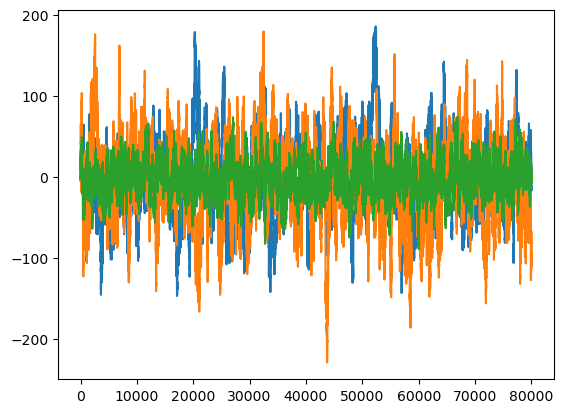

In [8]:
for i in range(3):
    plt.plot(x_trace[i,:])

Simulating the x trajectory and the f trajectory to then obtain the summary statistics, in this case the autocorrellation and the cross correllation in combination with the reduced energy production.

I don't know which formula we can pick to compute the reduce energy production, from autocorrellation, from cross correllation, all together?

ADD: Write a function GET_SUMMONER_STATISTICS() which is a list of functions, each function for a summoner statistic

In [9]:
C_xxs = []
C_fxs = []
S_red_all = []
S_redf_all = []
sum_stat_ac = []
sum_stat_cc = []

for i in range(n_sim):
    Cxx= corr(x_trace[i], x_trace[i], sampled_point_amount, dt=DeltaT) # compute the autocorrellation for each x trace
    Cfx = corr(f_trace[i], x_trace[i], sampled_point_amount, dt=DeltaT) # compute the cross-correllation for each x and f trace
    C_xxs.append(Cxx)
    C_fxs.append(Cfx)
    
    S1 = cumtrapz(Cxx, x=t, axis=-1, initial=0)
    S1 = cumtrapz(S1, x=t, axis=-1, initial=0)
    idx_corr = where((t>0)*(t<t_corr))[0]
    S_red = ((Cxx[0]-Cxx[idx_corr])+((mu_x[i]*k_x[i])**2)*S1[idx_corr])/(D_x[i]*t[idx_corr]) # compute the reduced energy production
    S_red_all.append(S_red)

    S2f = cumtrapz(Cfx - Cfx[0], x=t, axis=-1, initial=0)
    S3f = cumtrapz(Cfx, x=t, axis=-1, initial=0)
    S3f = -mu_x[i]*k_x[i]*cumtrapz(S3f, x=t, axis=-1, initial=0)
    S_redf = 1-(S2f[idx_corr]+S3f[idx_corr])/(D_x[i]*t[idx_corr]) # the energy production is to to the fluctuation-dissipation theorem
    S_redf_all.append(S_redf)

    inputx = concatenate((Cxx[idx_corr], S_red))  # concatenate to get the summary statistics
    sum_stat_ac.append(inputx)
    inputf = concatenate((Cxx[idx_corr], S_redf))  # concatenate to get the summary statistics
    sum_stat_cc.append(inputf)

print(f"The all x autocorrellation is {C_xxs[1]}")
print(f"The all f autocorrellation is {C_fxs[0]}")
print(f"The reduced energy production for x is {S_red_all[0]}")
print(f"The first summary statistic: autocorrellation of x_traces is {sum_stat_ac[0]}")
print(f"The second summary statistic: cross-correllation of x_traces and f_traces is {sum_stat_cc[0]}")

The all x autocorrellation is [ 2.54384532e+03  2.53300259e+03  2.52221629e+03 ... -2.64233264e-02
 -2.15859137e-02 -9.21264202e-03]
The all f autocorrellation is [7.36184475e-01 7.40204541e-01 7.44039925e-01 ... 1.08252125e-05
 7.72253959e-06 4.06003508e-06]
The reduced energy production for x is [20436.09528718 20505.99607628 20513.7984674  ...  5340.04689595
  5339.98012447  5339.91338057]
The first summary statistic: autocorrellation of x_traces is [2291.61712864 2285.81703432 2280.0494147  ... 5340.04689595 5339.98012447
 5339.91338057]
The second summary statistic: cross-correllation of x_traces and f_traces is [ 2.29161713e+03  2.28581703e+03  2.28004941e+03 ... -6.81298664e-01
 -6.81275029e-01 -6.81251394e-01]


Maybe we can select different summary statistics and usa some feature selection technique. If we use a lot of summary statistics maybe dimentionality reductions? PCA?
The idea is to use different summary statistics but to then to select the most important features of them deleting the correllations between them.

An example could be the Power spectral density for both x and f.
It can identify if there are any dominant frequencies in your data, or if the power is distributed across a range of frequencies, usefull for oscillatory behaviour

In [10]:
psds_x = []
psds_f = []
for i in range(len(x_trace)):
    frequencies_x, psd_x = welch(x_trace[i], fs=Sample_frequency, nperseg=sampled_point_amount/2)
    frequencies_f, psd_f = welch(f_trace[i], fs=Sample_frequency, nperseg=sampled_point_amount/2)
    psds_x.append(psd_x)
    psds_f.append(psd_f)

We can use directly the psds as input of the neural network or we can take some statistics about each one, like mean, median, max, min,variance, entropy, frequency of top power. We can think of more statistics

In [11]:
# Define the functions to compute the statistics
statistics_functions = [mean, var, median, max, min, lambda x: -sum(x*log(x)), lambda x: frequencies_x[x.argmax()]]

psds_x_statistics = zeros((len(psds_x), len(statistics_functions)))
psds_f_statistics = zeros((len(psds_f), len(statistics_functions)))

for i in range(len(psds_x)):
    for j, func in enumerate(statistics_functions):
        psds_x_statistics[i, j] = func(psds_x[i])
        psds_f_statistics[i, j] = func(psds_f[i])

In [12]:
print(f"The summoner statistic is {psds_x_statistics}")
print(f"The summoner statistic is {psds_f_statistics}")

The summoner statistic is [[ 1.27969608e-01  8.51225281e+00  2.88890762e-04  1.99758560e+02
   4.91476521e-06 -8.79958496e+03  4.00000000e+00]
 [ 1.28787816e-01  5.30348206e+00  5.40661160e-04  1.34758499e+02
   1.11303407e-05 -7.55760986e+03  2.00000000e+00]
 [ 2.40179412e-02  1.07061855e-01  1.91313142e-04  1.69629612e+01
   3.87804585e-06 -2.99021149e+02  1.60000000e+01]
 [ 4.87724245e-02  6.03058517e-01  3.01940134e-04  4.78964806e+01
   1.80639063e-06 -1.56817957e+03  1.80000000e+01]
 [ 7.51561224e-02  9.51776803e-01  5.84351597e-04  3.76765633e+01
   9.12260384e-06 -2.63323755e+03  2.00000000e+01]]
The summoner statistic is [[1.36326335e-05 6.71622388e-07 3.80818221e-09 9.65626240e-02
  6.44243131e-11 1.00170696e+00 1.00000000e+00]
 [4.82839387e-05 5.62680270e-06 3.68679132e-08 2.31611416e-01
  4.19199314e-10 2.92354679e+00 2.00000000e+00]
 [3.19774408e-04 5.70651202e-04 4.94144565e-08 3.04816818e+00
  1.24412869e-09 5.21523356e-01 1.00000000e+00]
 [6.54609394e-05 1.31300694e-05 

# INFERENCE STATISTICS

In [58]:
from torch import Tensor, Size
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from Utils_functions import prior_func
from numpy import squeeze

In [ ]:
n_sim = 10

In [59]:
prior_dist = prior_func(num_sim = n_sim)

## thing to forget

In [60]:
# check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior_dist)

In [61]:
print(f"The prior is {prior}")
print(f"The number of parameters is {num_parameters}")
print(f"The prior returns numpy is {prior_returns_numpy}")


The prior is BoxUniform(Uniform(low: torch.Size([9]), high: torch.Size([9])), 1)
The number of parameters is 9
The prior returns numpy is False


In [ ]:
# check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(Simulator_noGPU, prior, prior_returns_numpy)

In [ ]:
print(f"The simulator is {simulator}")

In [ ]:
theta = prior_dist.sample(Size((6,)))
theta.shape

Now we need to do a wrapper for the simulation since the simulator needs to take a single parameter.

In [ ]:
def simulator_wrapper(theta):
    # define the additional arguments required by the simulator function
    dt = 0.01
    DeltaT = 1
    TotalT = 100
    n_sim = 10
    # call the simulator function with the required arguments
    return Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta)

In [ ]:
# consistency check after making ready for sbi.
check_sbi_inputs(simulator_wrapper, prior_dist)

## True thing

In [47]:
import torch

Theta tensor shape (nsim, n_par)

In [48]:
new_theta = array(theta)[:,:,0].T

In [49]:
type(new_theta)

numpy.ndarray

In [51]:
new_theta_torch = torch.from_numpy(new_theta)

In [52]:
new_theta_torch.shape

torch.Size([5, 9])

X same dimensions as Theta

In [54]:
sum_stat_ac = torch.from_numpy(array(sum_stat_ac))

In [55]:
sum_stat_ac.shape

torch.Size([5, 159998])

In [56]:
C_xxs_torch = torch.from_numpy(array(C_xxs))

In [63]:
# check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior_dist)

In [65]:
infer = SNPE(prior=prior)

FailedPreconditionError: c:\Users\loren\OneDrive - Università degli Studi di Padova\MAGISTRALE UNIPD\Second semester\Laboratory of computational physics 2\LCPb-Project is not a directory

In [ ]:
"C:\Users\loren\OneDrive - Università degli Studi di Padova\MAGISTRALE UNIPD\Second semester\Laboratory of computational physics 2\LCPb-Project"